In [25]:
%matplotlib inline
import math
import torch 
from torch import nn 
from torch.nn import functional as F 
from d2l import torch as d2l

In [26]:
batch_size, num_steps = 32, 25
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码

In [27]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [28]:
X = torch.arange(10).reshape((2, 5)) # 批量大小，时间步数
F.one_hot(X.T, 28).shape             # 时间步数，批量大小，此表大小

torch.Size([5, 2, 28])

初始化模型参数

In [29]:
def get_params(vocab_size, num_hiddens, device):
    """
    初始化模型参数

    Parameters
    -----------
        vocab_size : 词表的大小
        num_hiddens : 隐藏单元数
        device : 设备
    """
    # 输入和输出来自相同的词表，所以维度相同
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params 

循环神经网络模型

In [30]:
def init_rnn_state(batch_size, num_hiddens, device):
    """隐状态初始化"""
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [31]:
def rnn(inputs, state, params):
    """
    在一个时间步内计算输出和隐状态
    
    Returns
    --------
        torch.cat(outputs, dim=0) : 输出, 是各词元的概率
        (H, ) : 隐状态
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状为(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q 
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, )

In [32]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, 
                 get_params, init_state, forward_fn):
        """ 
        Parameters
        -----------
            vocab_size : 词表大小
            num_hiddens : 隐藏单元数
            device : 设备
            get_params : 初始化模型参数，函数
            init_state : 隐状态初始化，函数
            forward_fn : 在一个时间步内计算隐状态和输出，函数
        """
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        """使对象可调用, 返回在一个时间步内计算的输出和隐状态"""
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32) # 独热编码
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        """初始化隐状态"""
        return self.init_state(batch_size, self.num_hiddens, device)


In [33]:
def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')

In [34]:
num_hiddens = 512 
net = RNNModelScratch(len(vocab), num_hiddens, try_xpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], try_xpu())
Y, new_state = net(X.to(try_xpu()), state)
Y.shape, len(new_state), new_state[0].shape
# 输出形状 时间步数 * 批量大小，词表大小
# 隐状态形状不变，批量大小，隐藏单元数

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

预测

In [35]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """
    在prefix后面生成新字符
    
    Parameters
    -----------
        prefix : 待预测字符的前缀
        num_preds : 待预测字符数
        net : RNN神经网络
        vocab : 类， 关于词表
        device : 设备
    """
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]  # vocab['char'] 返回该字符在词表中的编码
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1)) # 用最新输出，作为下一次的输入
    for y in prefix[1:]: # 预热期，利用前缀
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))  # y.argmax选出概率最大的词元编码(即下标)
    return ''.join([vocab.idx_to_token[i] for i in outputs])  # 输出，编码转换为词元

In [36]:
predict_ch8('time traveller ', 10, net, vocab, try_xpu())

'time traveller jkpuaqryxb'

梯度截断

In [37]:
def grad_clipping(net, theta):
    """截断梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params 
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm 


训练

In [39]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一轮(定义见第8章)"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和，词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是一个张量 
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是一个由张量组成的元组
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean() # long() 将张量y的数据类型转换为torch.long, 等同于torch.int64
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)  # 梯度截断
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [40]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型(定义见第8章)"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f}词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.2, 33008.0词元/秒 xpu:0
time traveller froued in anm dore aloigt enthe the time travelle
traveller surded the minct just the owit to efefinteat trea


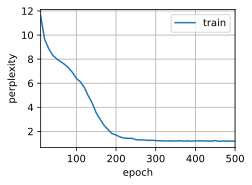

In [41]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, try_xpu())
# 默认vocab取1万个词元，所以模型设置更多轮数(500)来更好地收敛

困惑度 1.6, 30225.9词元/秒 xpu:0
time traveller proceeded anyreal body must havelength breadth th
travellerit would be remarkably convenient for the historia


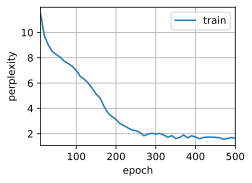

In [42]:
net = RNNModelScratch(len(vocab), num_hiddens, try_xpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, try_xpu(), use_random_iter=True)